# OCO-3 Snapshot Area Map (SAM) Exploration

While OCO-2 and OCO-3 use the same set of spectrometers, one development with OCO-3 has been the addition of a Pointing Mirror Assembly (PMA). The PMA allows for rapid changes in the pointing of the instrument, enabling data to be collected over contiguous 80km x 80km areas known as Snapshot Area Maps (SAMs). The science team maintains a repository of SAM acquisitions from throughout the mission on this webpage: [https://ocov3.jpl.nasa.gov/sams/](https://ocov3.jpl.nasa.gov/sams/)

In this notebook, we will look at SAMs acquired at one site in the Cascade Mountains region of the state of Oregon, United States. This region is composed predominantly of ponderosa pine trees and cedars with a sparse understory; vegetation cover is about 60%. By comparing SAM acquisitions over time, we can observe the seasonal changes in SIF for this ecoregion, as well as the changes due to disruption. As we will see later in the exercise, a major fire burned through this region in August 2020. Additionally, there is a [FLUXNET eddy covariance tower](https://ameriflux.lbl.gov/sites/siteinfo/US-Me2) located within the boundaries of this site that can be used as a "ground truth" comparison to the values we observe with OCO-3.

In [1]:
import contextily as ctx
from cartopy import crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import datetime
import json
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import sys


# Add src directory containing helper code to sys.path
sys.path.append(os.path.abspath("../src"))

from pysif import GesDiscDownloader, plot_samples

## I. Retrieving SAM Data

The [SAM webpage](https://ocov3.jpl.nasa.gov/sams/index.php) mentioned previously is a great place to start for finding specific sites and observations. In this exercise, we will be looking specifically at the `ecostress_us_me2` site, but you can pan through the map on the webpage to find a different area of interest on your own. If you put this site name and the site type ("SIF_Low", which can be found by clicking on the map pin for the site) into the search parameters, a list of all SAM observations at that site will be pulled up.  

<div align="center">
  <img src="images/ecostress_us_me2_map.png" alt="ecostress_us_me2 map pin">
</div>

These search results can tell us which dates we want to retrieve SIF granules for, and then filter those granules to only include soundings from the SAM mode, which is mode 2 in the granule. The retrieval itself can use the same code from the exploration notebook from earlier. To start let"s take the first SAM observation with a non-zero amount of soundings, which we can see from the search results occurred on May 28th, 2020:

<div align="center">
  <img src="images/sam_search_result.png" alt="SAM mode search result">
</div>

In [8]:
dl = GesDiscDownloader()

dataset = "OCO3_L2_Lite_SIF.11r"
data_date = datetime(2020, 5, 28)
granule = dl.get_granule_by_date(dataset, data_date)

Checking available dates on GES DISC for OCO3_L2_Lite_SIF.11r


Now that we have the granule, we can filter the data to just SAM soundings. You can find more information about OCO-3"s measurement modes in the [User's Guide](https://docserver.gesdisc.eosdis.nasa.gov/public/project/OCO/OCO2_v11.2_OCO3_v11_SIF_Data_Users_Guide.pdf), see Section 4.7 "The Metadata Group". Measurement Mode 3 is referred to as an AreaMap -- this is the SAM mode we are interested in.

In [ ]:
# Get the measurement mode of the data first so we can filter to just use SAM mode soundings
# Additionally, we will remove low quality soundings
meas_mode = np.array(granule["Metadata_MeasurementMode"].data[:])
qual_flag = np.array(granule["Quality_Flag"].data[:])
sam_mask  = (meas_mode == 3) & ((qual_flag == 0) | (qual_flag == 1))

all_lat = granule["Latitude"].data[:]
all_lon = granule["Longitude"].data[:]
all_sif = granule["Daily_SIF_757nm"].data[:]

lat = all_lat[sam_mask]
lon = all_lon[sam_mask]
sif = all_sif[sam_mask]

sam_extent = [-123.9, -120.4, 43.3, 45]
# sam_extent = [-122.6, -120.4, 44, 45.7]

# Using the plot_samples function from the first notebook gives us a good first look at this data
# before further processing. The YlGn colormap is used to make it easier to compare the data with
# the official plot.
plot_samples(
    sif, lat, lon,
    vmin=-0.05,
    vmax=0.55,
    cmap="YlGn",
    point_size=15,
    fig_size=(8, 8),
    extents=sam_extent,
    title=f"OCO-3 SAM mode LtSIF 757 nm ({data_date.strftime('%Y-%m-%d')})",
    label=r"Daily SIF 757 nm (W/$\mathrm{m}^2$/sr/μm)"
)

### Comparison with official plot
If you've been following along on the OCO-3 website, you may have noticed that the science team provides pre-made plots of a variety of measurements for each SAM acquisition. Let's take a look at one of these plots for the OCO-3 LtSIF 757nm variable:

<div style="text-align:center">
  <img style="width:640px" src="images/OCO3_Lite_B11074Ar_r02_sif_757nm_20200528_6040_ecostress_us_me2.png" alt="Official OCO-3 SAM mode plot for May 28, 2020">
</div>

If the previous code ran successfully for you, you should be able to see that our plot is already comparable to the official one and that we are at least looking at the same data but with some superficial differences in presentation. In the next section, we will refine our plot to look like the official version. The most important component of this will be to adjust each sounding to use its proper footprint extents.

In [ ]:
all_footlat = granule["Geolocation_footprint_latitude_vertices"].data[:]
all_footlon = granule["Geolocation_footprint_longitude_vertices"].data[:]
footprint_lat = all_footlat[sam_mask][:]
footprint_lon = all_footlon[sam_mask][:]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.GOOGLE_MERCATOR)

ax.set_extent(sam_extent, crs=ccrs.PlateCarree())

patches_list = []
for i in range(len(sif)):
    polygon = patches.Polygon(np.column_stack([footprint_lon[i], footprint_lat[i]]))
    patches_list.append(polygon)

pcol = PatchCollection(
    patches_list,
    cmap="YlGn",
    transform=ccrs.PlateCarree()
)

pcol.set_array(np.array(sif))
pcol.set_clim(-0.01, 0.55)
sif_layer = ax.add_collection(pcol)

ctx.add_basemap(
    ax,
    source=ctx.providers.Esri.WorldImagery,
    crs=ccrs.GOOGLE_MERCATOR,
    zoom=9
)

# Add gridlines over the map. Note that we can use the default LATITUDE_FORMATTER and
# LONGITUDE_FORMATTER from cartopy to make our lives easier
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color="white", alpha=0.7, linestyle="-")
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {"size": 14, "color": "black"}
gl.ylabel_style = {"size": 14, "color": "black"}

plt.title(f"OCO-3 SAM mode LtSIF 757 nm ({data_date.strftime("%Y-%m-%d")})", fontsize=16)
cbar = plt.colorbar(sif_layer, ax=ax, extend="both", pad=0.01)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r"Daily SIF 757 nm [W/$\mathrm{m}^2$/sr/μm]", fontsize=16, rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

## II. Using Ground-Based Data from an Ameriflux Tower

Ameriflux towers use [eddy covariance](https://en.wikipedia.org/wiki/Eddy_covariance) to measure carbon dioxide exchange in the atmosphere just above the Earth's surface. This measurement can be used to determine Net Ecosystem Exchange (NEE) and Gross Primary Production (GPP) of vegetation at the local ecosystem level within ~1km around the tower site. EC Flux towers measure data continuously at timescales as frequent as every half-hour, so they provide an important source of ground truth when validating satellite-based measurements and observing data relationships. The figure below illustrates the spatial scale of tower observations as compared with remote sensing.

<div style="text-align:center">
  <img style="width:640px" src="images/scale.png" alt="A diagram showing the scale of various methods for measuring vegetation primary productivity">
</div>

To begin, we will plot the GPP data contained in the provided `AMF_US-Me2_FLUXNET_SUBSET_DD_2019-2022.csv` file. This file was obtained using the "Download Data" functionality on the [Ameriflux page for the tower](https://ameriflux.lbl.gov/sites/siteinfo/US-Me2). Downloading data requires an account, so this step has already been done for your convenience. The Ameriflux data is presented at several time scales ranging from yearly to hourly, and for this analysis we are just using the daily data. An abridged version of the daily data is included in the notebooks directory containing just the entries for August 2019 through the end of 2022. Hence, the file naming convention can be understood like so:

> `AMF_US-Me2_FLUXNET_SUBSET_DD_2019-2022.csv`
> * `AMF` = Ameriflux
> * `US-Me2` = tower site name, United States Metolius-2
> * `FLUXNET` = fluxnet data, as opposed to BADM or other ancillary datasets
> * `SUBSET` = this file contains only a subset of the full set of measurements available for the tower. The available measurements are documented on the webpage.
> * `DD` = Daily time cadence
> * `2019-2022` = File has been edited to contain only relevant dates. This is not normally in the file name and was added later.

**In the following code block, we will compare two methods for retrieving GPP, the Daytime (DT) and Nighttime (NT) partionining Variable Ustar Threshold (VUT) algorithms.**

For more information on the theoretical basis of these GPP retrievals, please see [Pastorello et al., 2020](https://doi.org/10.1038/s41597-020-0534-3) which discusses the FLUXNET pipeline, as well as [Barr et al., 2013](https://doi.org/10.5194/bg-10-2145-2013) and [Papale et al., 2006](https://doi.org/10.5194/bg-3-571-2006) for details about the algorithms.

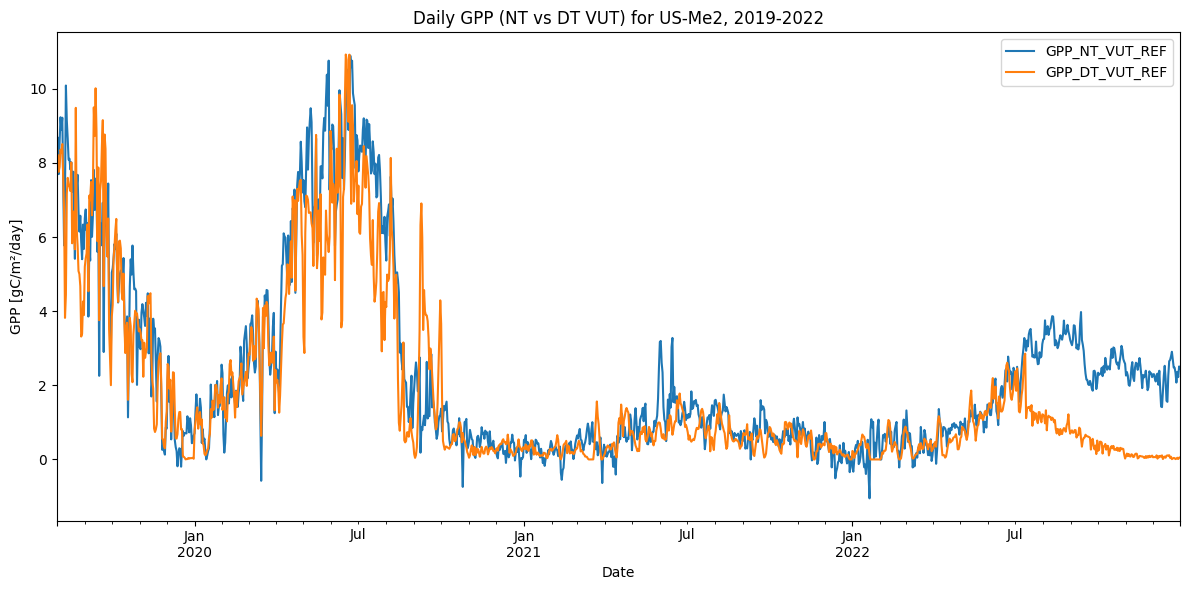

In [6]:
# Read the file
gpp_file = "AMF_US-Me2_FLUXNET_SUBSET_DD_2019-2022_4-6.csv"
# strip metadata rows that start with #
df = pd.read_csv(gpp_file, comment='#')

# Parse the timestamp column
# FLUXNET daily timestamps are usually yyyymmdd as an int/str.
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], format='%Y%m%d')
df = df.set_index('TIMESTAMP')

# Select the two "REF" GPP columns
cols = [
    "GPP_NT_VUT_REF",
    "GPP_DT_VUT_REF"
]
gpp = df[cols]

# Plot as a time series
plt.figure(figsize=(12, 6))
gpp.plot(ax=plt.gca())
plt.xlabel("Date")
plt.ylabel("GPP [gC/m²/day]")
plt.title("Daily GPP (NT vs DT VUT) for US-Me2, 2019-2022")
plt.tight_layout()
plt.show()


### What can we notice about this plot?

To start, note that the two algorithms are quite similar through most of the observed period until July 2022, at which point the daytime partitioning method diverges from the nighttime method and approaches 0 gC/m²/day.

Another key observation about this site is GPP follows a consistent annual cycle prior to August 2020, then is depressed in subsequent two years. The earlier data shows the seasonal cycle of primary production in a healthy forest ecosystem, followed by the resulting loss in productivity after the August 2020 wildfire in this region. There is a slight peak in GPP in the summer of 2021 with a higher peak in summer 2022 that can be attributed to seral growth in the burn region.

**Question: How do you expect an ecological disruption like the wildfire will affect the ability to discern a SIF-GPP relationship between OCO-3 data and tower data?**

## III. Comparison of OCO-3 SIF with Ameriflux Tower GPP Data

In this section, we will compare daily averaged SIF from OCO-3 against tower GPP data from the US-Me-2 site. Ultimately, we will create a daily time-scale plot comparing available data from the two datasets over the period from August 2019 (the beginning of the OCO-3 mission) through the end of 2022 (the end of the Ameriflux data for this tower as of the writing of this training). This plot will look similar to figure 3b from [Pierrat et al., 2022](https://doi.org/10.1029/2021JG006588). If you wish to explore the data from that paper and other tower-based SIF and GPP measurements further, you can find the associated dataset here: [https://doi.org/10.5281/zenodo.10048770](https://doi.org/10.5281/zenodo.10048770) and a supporting webpage here: [https://climatesciences.jpl.nasa.gov/sif/download-data/tower/](https://climatesciences.jpl.nasa.gov/sif/download-data/tower/)

### Pre-processing

Several pre-processing steps have already been taken for you. First, you will notice there is an ancillary file called "us_me2_oco3_dates.json" in the same directory as this notebook. This JSON file was created by studying all available data dates across the OCO-3 mission from August 2019 - December 2022 to determine when soundings within a 0.5-degree radius around the tower site were acquired, and to store the relevant locations within the granule that those soundings occurred. This search process was performed using the code sample in the Appendix notebook, so we will just discuss it conceptually here. By looping through each date in the time range of interest, we can search for (longitude, latitude) coordinate pairs that lie within the defined bounding box: in this case, $\pm 0.25^{\circ}$ around the tower coordinates. In the next part of the pre-processing, we extract the relevant data from each discovered granule and take the mean of all 757nm SIF data with a Quality Flag value of 0 (best) or 1 (good). The spatial means are stored in a separate JSON file that will be used as the basis for our daily SIF values in the comparison plot.

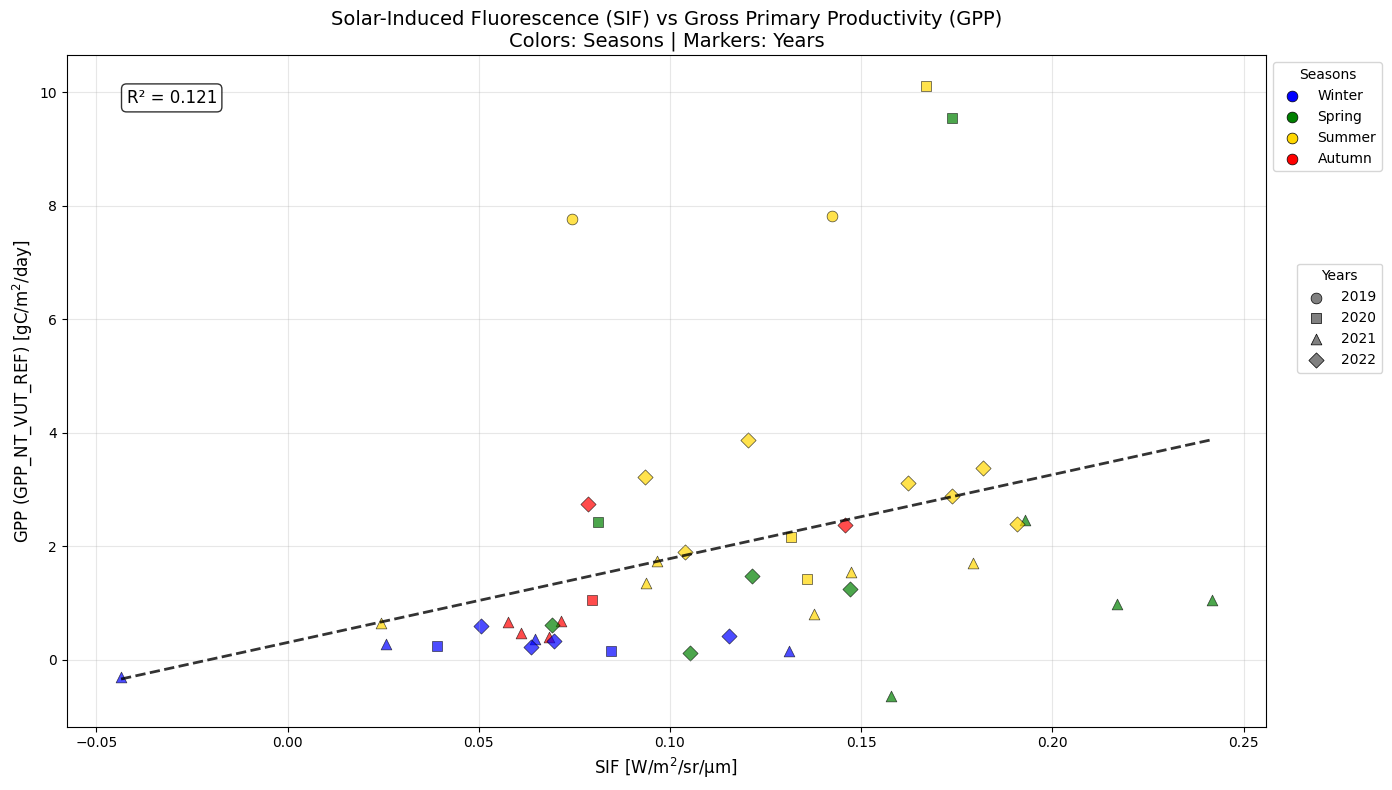

In [ ]:
def load_sif_data(json_file):
    """Load SIF data from JSON file"""
    with open(json_file, "r") as f:
        data = json.load(f)
    
    # Convert to DataFrame
    df = pd.DataFrame(data["dates"])
    df["date"] = pd.to_datetime(df["date"])
    return df

def load_gpp_data(csv_file, gpp_column="GPP_NT_VUT_REF"):
    """Load GPP data from CSV file"""
    df = pd.read_csv(csv_file)
    
    # Convert TIMESTAMP to datetime
    df["date"] = pd.to_datetime(df["TIMESTAMP"], format="%Y%m%d")
    
    # Select relevant columns
    df = df[["date", gpp_column]].copy()
    df.rename(columns={gpp_column: "gpp"}, inplace=True)
    
    return df

def add_temporal_features(data):
    """Add year and season columns to the data"""
    data = data.copy()
    
    # Extract year
    data["year"] = data["date"].dt.year
    
    # Extract month and map to seasons
    month = data["date"].dt.month
    data["season"] = month.map({
        12: "winter", 1: "winter", 2: "winter",
        3: "spring", 4: "spring", 5: "spring",
        6: "summer", 7: "summer", 8: "summer",
        9: "autumn", 10: "autumn", 11: "autumn"
    })
    
    return data

def merge_and_clean_data(sif_df, gpp_df):
    """Merge SIF and GPP data on date and remove invalid values"""
    # Merge on date
    merged = pd.merge(sif_df, gpp_df, on="date", how="inner")
    
    # Remove rows with NaN or negative values
    merged = merged.dropna()
    
    # Remove rows where GPP is the fill value, -9999
    merged = merged[merged["gpp"] != -9999]
    merged = merged[merged["sif"] != 0]
    
    # Add temporal features
    merged = add_temporal_features(merged)
    
    return merged

def create_scatter_plot(data, gpp_column_name="GPP_NT_VUT_REF", mark_years=False, print_stats=False):
    """Create scatter plot with linear regression, seasonal colors, and yearly markers"""
    # Extract x and y values
    x = data["sif"].values.reshape(-1, 1)
    y = data["gpp"].values

    # Fit linear regression
    reg = LinearRegression()
    reg.fit(x, y)
    y_pred = reg.predict(x)
    r2 = r2_score(y, y_pred)
    
    # Create figure
    plt.figure(figsize=(14, 8))
    
    # Define color mapping for seasons
    season_colors = {
        "winter": "blue",
        "spring": "green",
        "summer": "gold",
        "autumn": "red"
    }
    
    if mark_years:
        year_markers = {
            2019: "o",  # circle
            2020: "s",  # square
            2021: "^",  # triangle up
            2022: "D"   # diamond
        }
        title_addon = " | Markers: Years"
    else:
        year_markers = {y: "o" for y in range(2019, 2023)}
        title_addon = ""
    
    # Create scatter plot with seasonal colors and yearly markers
    for year in sorted(data["year"].unique()):
        for season in ["winter", "spring", "summer", "autumn"]:
            # Filter data for this year and season
            mask = (data["year"] == year) & (data["season"] == season)
            subset = data[mask]
            
            if len(subset) > 0:
                plt.scatter(
                    subset["sif"], 
                    subset["gpp"],
                    c=season_colors[season],
                    marker=year_markers[year],
                    s=60,
                    alpha=0.7,
                    edgecolors="black",
                    linewidth=0.5,
                    label=f"{year} {season}" if len(plt.gca().get_legend_handles_labels()[0]) < 16 else ""
                )
    
    # Plot regression line
    x_sorted = np.sort(data["sif"].values)
    y_pred_sorted = reg.predict(x_sorted.reshape(-1, 1))
    plt.plot(x_sorted, y_pred_sorted, color="black", linewidth=2, linestyle="--", alpha=0.8)
    
    # Add R² value to plot
    plt.text(0.05, 0.95, f"R² = {r2:.3f}", 
             transform=plt.gca().transAxes, 
             fontsize=12, 
             verticalalignment="top",
             bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))
    
    # Labels and title
    plt.xlabel(r"SIF [W/$\mathrm{m}^2$/sr/μm]", fontsize=12)
    plt.ylabel(f"GPP ({gpp_column_name}) " + r"[gC/$\mathrm{m}^2$/day]", fontsize=12)
    plt.title(f"Solar-Induced Fluorescence (SIF) vs Gross Primary Productivity (GPP)\nColors: Seasons{title_addon}", fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Season legend (colors)
    season_handles = [plt.scatter([], [], c=color, s=60, marker='o', edgecolors="black", linewidth=0.5) 
                     for season, color in season_colors.items()]
    season_labels = [season.capitalize() for season in season_colors.keys()]

    legend1 = plt.legend(season_handles, season_labels, title="Seasons", 
                        loc='upper left', bbox_to_anchor=(1, 1))
    
    if mark_years:
        # Year legend (markers)
        year_handles = [plt.scatter([], [], c='gray', marker=marker, s=60, edgecolors="black", linewidth=0.5) 
                    for year, marker in year_markers.items()]
        year_labels = [str(year) for year in year_markers.keys()]

        legend2 = plt.legend(year_handles, year_labels, title="Years", 
                            loc='upper left', bbox_to_anchor=(1.02, 0.7))
        
        # Add the first legend back (matplotlib removes it when creating the second)
        plt.gca().add_artist(legend1)
    
    if print_stats:
        # Print statistics
        print(f"Number of matched data points: {len(data)}")
        print(f"Linear regression equation: y = {reg.coef_[0]:.3f}x + {reg.intercept_:.3f}")
        print(f"R² value: {r2:.3f}")
        print(f"Slope: {reg.coef_[0]:.3f}")
        print(f"Intercept: {reg.intercept_:.3f}")
    
    plt.tight_layout()
    plt.show()


# File paths
sif_file = "us_me2_oco3_sif.json"
gpp_file = "AMF_US-Me2_FLUXNET_SUBSET_DD_2019-2022_4-6.csv"

# Change this to use a different GPP column, e.g., GPP_DT_VUT_REF
gpp_column = "GPP_NT_VUT_REF"

try:
    sif_data = load_sif_data(sif_file)
    
    gpp_data = load_gpp_data(gpp_file, gpp_column)
    
    merged_data = merge_and_clean_data(sif_data, gpp_data)
    
    # Set mark_years to True if you would like different years of data
    # to receive different markers on the plot
    # Set print_stats to True if you would like a printout of info
    # about the linear regression
    create_scatter_plot(
        merged_data,
        gpp_column,
        mark_years=False,
        print_stats=False
    ) 
except FileNotFoundError as e:
    print(f"Error: File not found - {e}")
except Exception as e:
    print(f"Error: {e}")


### What can we notice about this plot?

Although the linear relationship between SIF and GPP is well established in the literature, our R² result of around 0.12 suggests that these variables are nearly uncorrelated. This portion of the exercise is included to instruct on an important pitfall that can be encountered when comparing datasets at different spatial resolutions. It is important to note that when disruptions like wildfires occur in an ecosystem, affected and unaffected areas can be spatially close to one another. Although the area directly around the US-Me-2 tower was burned in the wildfire, some regions of forest within 20km did not. SAM mode acquisitions can help us to identify and diagnose this unexpectedly poor correlation. Let's create another SAM plot similar to the one from section I for one of the points in the above plot where SIF was high but GPP was low. The rightmost point on the plot corresponds with the date 2021-05-28. This time, we will also add a marker to the plot to show where the tower is.

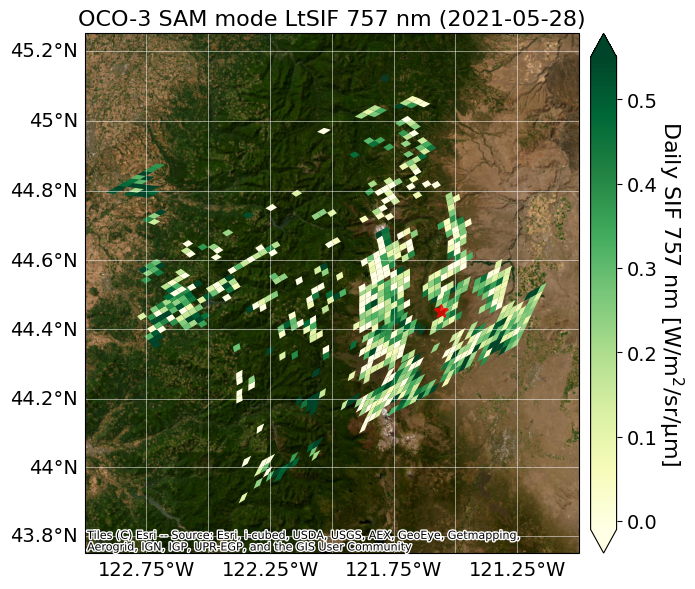

In [15]:
# Follow the same procedure as in Section 1 but for 2021-05-28
data_date_2 = datetime(2021, 5, 28)
# Extent may need to be modified slightly per SAM mode acquisition
sam_extent_2 = [-123, -121, 43.75, 45.25]
granule = dl.get_granule_by_date(dataset, data_date_2)

meas_mode = np.array(granule["Metadata_MeasurementMode"].data[:])
qual_flag = np.array(granule["Quality_Flag"].data[:])
sam_mask  = (meas_mode == 3) & ((qual_flag == 0) | (qual_flag == 1))

all_lat = granule["Latitude"].data[:]
all_lon = granule["Longitude"].data[:]
all_sif = granule["Daily_SIF_757nm"].data[:]

lat = all_lat[sam_mask]
lon = all_lon[sam_mask]
sif = all_sif[sam_mask]

all_footlat = granule["Geolocation_footprint_latitude_vertices"].data[:]
all_footlon = granule["Geolocation_footprint_longitude_vertices"].data[:]
footprint_lat = all_footlat[sam_mask][:]
footprint_lon = all_footlon[sam_mask][:]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.GOOGLE_MERCATOR)

ax.set_extent(sam_extent_2, crs=ccrs.PlateCarree())

# Add a marker with the tower location to the plot. These coordinates can be found on the Ameriflux site
ax.plot(-121.5589, 44.4526, marker='*', color='red', markersize=10, alpha=0.7, transform=ccrs.Geodetic())

patches_list = []
for i in range(len(sif)):
    polygon = patches.Polygon(np.column_stack([footprint_lon[i], footprint_lat[i]]))
    patches_list.append(polygon)

pcol = PatchCollection(
    patches_list,
    cmap="YlGn",
    transform=ccrs.PlateCarree()
)

pcol.set_array(np.array(sif))
pcol.set_clim(-0.01, 0.55)
sif_layer = ax.add_collection(pcol)

ctx.add_basemap(
    ax,
    source=ctx.providers.Esri.WorldImagery,
    crs=ccrs.GOOGLE_MERCATOR,
    zoom=9
)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color="white", alpha=0.7, linestyle="-")
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {"size": 14, "color": "black"}
gl.ylabel_style = {"size": 14, "color": "black"}

plt.title(f"OCO-3 SAM mode LtSIF 757 nm ({data_date_2.strftime("%Y-%m-%d")})", fontsize=16)
cbar = plt.colorbar(sif_layer, ax=ax, extend="both", pad=0.01)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r"Daily SIF 757 nm [W/$\mathrm{m}^2$/sr/μm]", fontsize=16, rotation=270, labelpad=20)

plt.tight_layout()
plt.show()


In the above plot, we can see that there is no SIF sample directly over the tower site. The fact that SAM observations, despite providing improved spatial coverage compared with the more common nadir and glint modes, still contain gaps informs the necessity of using the spatial aggregation technique described at the beginning of this section and included in the appendix. One challenge of spatial aggregation, however, is that we can see that SIF varies greatly even between adjacent samples. In particular, note the region of higher SIF pixels at the higher altitude forest regions to the west of the tower, as well scattered pixels above the colorbar maximum in the valley to the southeast, lying over irrigated cropland. Depending on the context of the tower site in your own research, it is worth considering the following additional techiques:

* **Reducing the spatial aggregation window**, which will reduce the number of samples considered but potentially exclude non-representative biomes. In the appendix, you can test this by reducing the value of the `tolerance` variable to 0.125
* **Filtering data by biome type**, this can allow you to consider a wider spatial window while still taking into account varying biomes. In the appendix, you can test this by uncommenting this portion of the filtering step: `cond = (qual_flag < 2) & ((igbp_type == 1) + (igbp_type == 5))`
* **Correlating the local solar time of the SAM data to hourly tower data**. Each data point in a granule contains a UTC time associated with the overflight time. As SAMs are acquired over a period of several minutes, this can be compared with the nearest hour in the tower GPP data. 